# Assignment Sheet 4

Bruce Schultz  
bschultz@uni-bonn.de  
  
Miguel A. Ibarra-Arellano  
ibarrarellano@gmail.com

## Exercise 1

## Exercise 2

In [1]:
import numpy as np
import imageio
from skimage import color
from sklearn import mixture
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import pandas as pd
from gaussian_mixture_model import *
from PIL import Image

**a) Read the grayscale image brain.png, which is provided on the lecture homepage. Reduce the salt
and pepper noise in the image using a median filter. (3P)**

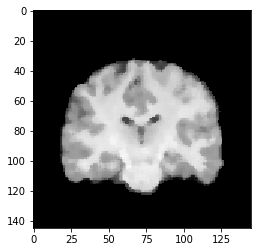

In [6]:
# Read image into array data
raw_img_read = plt.imread("brain-noisy.png", True)

# Denoising image
mf_img = ndimage.median_filter(raw_img_read, size=5)

plt.imshow(mf_img)

**b) Produce a binary mask that marks all pixels with an intensity greater than zero. In all further
steps, only treat pixels within that mask. (1P)**

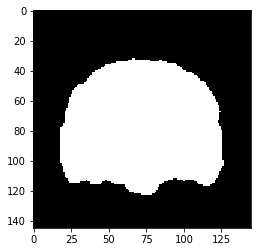

In [7]:
# Creating binary mask
binary_mask = mf_img > 0  # Any value greater than 0 (background)
bin_masked_img = mf_img.copy()
bin_masked_img[binary_mask] = 255  # 255 == white

plt.imshow(bin_masked_img)

**c) Plot a log-scaled histogram of the pixels within the mask. It should show how frequently different
intensity values occur in the image. What do the peaks in this histogram represent? Hint: One
way to and out is to create masks that highlight the pixels belonging to each peak. (4P)**

Text(0.5,1,'Brain image by pixel value')

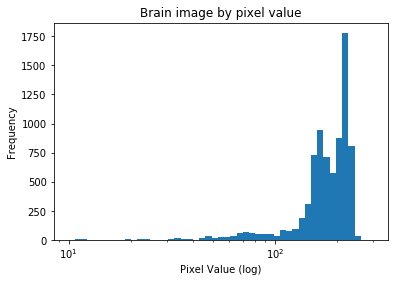

In [35]:
# Plot values from non-background pixels on a log scaled histogram
bins = 50
plt.gca().set_xscale("log")
counts, pixels, bars = plt.hist(mf_img[binary_mask], np.logspace(np.log10(10), np.log10(300), bins))
plt.xlabel("Pixel Value (log)")
plt.ylabel("Frequency")
plt.title("Brain image by pixel value")
# plt.show()  # Peaks refer to segmentation thresholds, gray/white matter and background


The peaks in this plot represent the different classes within the image, specifically the different parts of the brain. Each peak shows the pixel intensity that is most associated with that brain anatomy.

In [ ]:
plt.close()
# Create masks for the pixel values surrounding each peak in histogram

# Determine histogram peaks and the corresponding pixel value
peak_values = []
threshold = 75
for i in range(len(counts)-1):
    if counts[i] > threshold and counts[i] > counts[i-1] and counts[i] > counts[i+1]:
        peak_values.append(pixels[i])

#  Visualize image with peak pixel value locations after converting to RGB array
masks = []
pix_range = 40  # To give an acceptable range for pixel values
for pix_value in peak_values:
    masks.append(np.logical_and(pix_value+pix_range >= mf_img, mf_img >= pix_value-pix_range))

peak_img = bin_masked_img.copy()
peak_img = color.gray2rgb(peak_img)  # Convert to RGB array
prime_colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255]]  # Define primary colors [R, G, B]
for counter, mask in enumerate(masks):
    if counter > 2:
        break
    peak_img[mask] = prime_colors[counter]
    
plt.imshow(peak_img)

Note that since I only used pixel intensities that were within 40 units of each peak, some pixels in the image remain white as they were not included in the range

**d) Now, we will use a three-compartment Gaussian Mixture Model for image segmentation: Based
on their gray level, pixels that fall within the mask from c) should be assigned to one of three
Gaussians, capturing corticospinal 
uid (dark), gray matter (medium), or white matter (bright).
To start this process, initialize the parameters of a three-compartment GMM to some reasonable
values and use them to compute the responsibilities pik of cluster k for pixel i. (4P)**

In [42]:
# Create some GMM functions

from random import randint
from math import pi, exp, sqrt
import numpy as np


def GMM_init(data_points, n_distributions, means_init=None):
    """
    Initializes N gaussian distributions for use in GMM modeling
    :param data_points: 2D array containing data of interesting for GMM
    :param n_distributions: Number of clusters predicted to be found
    :param means_init: Optional, means to start the clustering process
    :return: Separate 1D arrays for mixing coefficients, variance values, and means
    """
    mix_coeff = [1/n_distributions] * n_distributions  # Sum of pi across all clusters must = 1
    if means_init is not None:
        means = means_init[:, 1]  # Set initial means to user specified values
    else:
        # Random initialization using y values ([:,1])
        means = [randint(min(data_points[:, 1]), max(data_points[:, 1])) for i in range(n_distributions)]

    # Initialize variance to sig**2 = sum(X-mu)**2 / N
    init_variance = sum([(data_points[i, 1]-min(means))**2 for i in range(len(data_points[:, 1]))])
    sigma = [sqrt(init_variance/len(data_points[:, 1]))] * n_distributions
    return mix_coeff, sigma, means

# TODO implement k-means init

# E-step of GMM algorithm
def GMM_responsibilities(data_points, n_distributions, mix_coeff, sigma, means):

    # Calculate gaussians
    # GMM array has x values in first column and GMM sum value in the last column
    GMM_array = np.empty((len(data_points[:, 1]), n_distributions + 2))
    GMM_array[:, 0] = data_points[:, 1]  # First column is our values
    for i in range(len(data_points[:, 1])):  # Iterate through values
        for k in range(n_distributions):  # Iterate through clusters
            gauss = 1/(sqrt(2*pi)*sigma[k])*exp(-((data_points[i, 1]-means[k])**2)/(2*(sigma[k]**2)))
            GMM_array[i, k+1] = mix_coeff[k]*gauss
        GMM_array[i][n_distributions + 1] = sum(GMM_array[i][1:n_distributions+1])  # Sum N(x|uk, sigk**2) (Gauss_dis) values

    # Calculate responsibilities
    responsibilities = np.empty((len(data_points[:, 1]), n_distributions))
    for i in range(len(data_points[:, 1])):
        for k in range(n_distributions):
            responsibilities[i][k] = GMM_array[i, k+1]/GMM_array[i, n_distributions+1]

    # Only responsibilities values! i (sample #) rows by k (cluster #) columns
    return responsibilities


# M-step of GMM algorithm
def GMM_optimize(data_points, n_distributions, mix_coeff, sigma, means):

    rho = GMM_responsibilities(data_points, n_distributions, mix_coeff, sigma, means)

    # Create lists to fill with optimized values
    opt_mix_coeff = [0] * len(mix_coeff)
    opt_means = [0] * len(means)
    opt_sigma = [0] * len(sigma)

    # Optimize parameters
    for k in range(n_distributions):
        cluster_resp_sum = sum(rho[:, k])

    # Mixing Coefficients
        opt_mix_coeff[k] = cluster_resp_sum / len(data_points[:, 1])

    # Means
        mean_numerator = sum([rho[i][k]*data_points[i][1] for i in range(len(data_points[:,1]))])
        opt_means[k] = mean_numerator/cluster_resp_sum

    # Sigma
        sig_numerator = sum([(rho[i][k]*((data_points[i][1]-means[k])**2)) for i in range(len(data_points[:, 1]))])
        opt_sigma[k] = sqrt(sig_numerator/cluster_resp_sum)

    return opt_mix_coeff, opt_sigma, opt_means, rho


def GMM_convergence(data_points, n_distributions, iterations=25, means_init=None, only_init=False):
    mix_coeff, sigma, means = GMM_init(data_points, n_distributions, means_init)

    if only_init:
        rho = GMM_responsibilities(data_points, n_distributions, mix_coeff, sigma, means)
        return mix_coeff, sigma, means, rho

    # Create list to track changes with every iteration
    mix_coefficient_list = [list(mix_coeff)]
    sigma_list = [list(sigma)]
    means_list = [list(means)]

    i = 0
    while i < iterations:
        mix_coeff, sigma, means, rho = GMM_optimize(data_points, n_distributions, mix_coeff, sigma, means)
        mix_coefficient_list.append(mix_coeff)
        sigma_list.append(sigma)
        means_list.append(means)
        i += 1
    return mix_coefficient_list, sigma_list, means_list, rho


def pixel_cluster_matcher(mask_template, cluster_assignment_list, cluster_number):
    """
    Uses a mask template to determine pixel location and iterates over new mask, changing Boolean\
    values to false if they don't match cluster_number
    :param mask_template: Mask_template to use to determine pixels of interest to change bool values
    :param cluster_assignment_list: 1D array with cluster assignment for every pixel that is True in mask_template
    :param cluster_number: Which cluster you are building this mask for
    :return: Mask with True values for only pixels at specified cluster_number location
    """
    new_mask = mask_template.copy()
    k = 0
    for pixel in np.nditer(new_mask, op_flags=['readwrite']):
        if pixel[...]:
            if cluster_assignment_list[k] != cluster_number:
                pixel[...] = False
            k += 1
    return new_mask


# TODO Make this iterate and fix functions to work together better -- use OOP?

In [40]:
# Create 2D array with pixel number (x value) and pixel intensity (y value)
gmm_data = np.column_stack(enumerate(mf_img[binary_mask])).transpose()
points_init = np.array([[1, 2, 3], peak_values]).transpose()

# Use homemade GMM functions to predict pixel clustering using only 1 iteration and no optimization
mix_coeff, sigma, means, responsibilities = GMM_convergence(gmm_data, 3,
                                                            iterations=iter, means_init=points_init, only_init=True)

cluster_predictions = [np.argmax(sample) for sample in responsibilities]
cluster_probabilities = [np.amax(sample) for sample in responsibilities]

**e) Visualize the responsibilities by mapping the probabilities of belonging to the CSF, gray matter,
and white matter clusters to the red, blue, and green color channels, respectively. Please submit
the resulting image. (3P)**

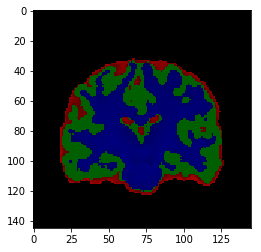

In [43]:
# Copy the binary mask image and convert to RGB
gmm_img = bin_masked_img.copy()
gmm_img = color.gray2rgb(gmm_img)

# Create masks for CSF, gray/white matter then assign them color layers
csf_mask = pixel_cluster_matcher(binary_mask, cluster_predictions, 0)
gray_mask = pixel_cluster_matcher(binary_mask, cluster_predictions, 1)
white_mask = pixel_cluster_matcher(binary_mask, cluster_predictions, 2)

gmm_img[csf_mask] = [255, 0, 0]
gmm_img[gray_mask] = [0, 255, 0]
gmm_img[white_mask] = [0, 0, 255]

# Multiply each value by the probability of that pixel belonging to that class (darker == less probable)
gmm_img[binary_mask] = [[value*cluster_probabilities[i] for value in pixel] for i, pixel in enumerate(gmm_img[binary_mask])]

plt.imshow(gmm_img)

**f) Use the update rules provided in the lecture to re-compute the parameters muk, sigmak, and pik. (4P)**

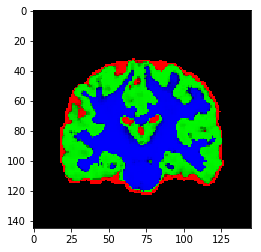

In [62]:
# Using my homemade GMM algorithm until convergence
iter = 30
mix_coeff, sigma, means, responsibilities = GMM_convergence(gmm_data, 3, iterations=iter, means_init=points_init)

cluster_predictions = [np.argmax(sample) for sample in responsibilities]
cluster_probabilities = [np.amax(sample) for sample in responsibilities]

# Create masks for CSF, gray/white matter then assign them color layers
csf_mask = pixel_cluster_matcher(binary_mask, cluster_predictions, 0)
gray_mask = pixel_cluster_matcher(binary_mask, cluster_predictions, 1)
white_mask = pixel_cluster_matcher(binary_mask, cluster_predictions, 2)

gmm_img[csf_mask] = [255, 0, 0]
gmm_img[gray_mask] = [0, 255, 0]
gmm_img[white_mask] = [0, 0, 255]

# Multiply each value by the probability of that pixel belonging to that class (darker == less probable)
gmm_img[binary_mask] = [[value*cluster_probabilities[i] for value in pixel] for i, pixel in enumerate(gmm_img[binary_mask])]

plt.imshow(gmm_img)

Here I increased the iterations to 30. When iterations > 0, then the optimizing function from above kicks in and update the parameters

**g) Iterate the E and M steps of the algorithm until convergence. Please submit the final parameter
values, a visualization of the final responsibilities, and your code. (3P)**

In [59]:
print('Mixing Coefficients:', mix_coeff[-1], '\nVariances:', sigma[-1], '\nMeans:', means[1], '\n\nResponsibilities:')
respons_df = pd.DataFrame(responsibilities, columns=['Cluster 1', 'Cluster 2', 'Cluster 3'])
print(respons_df.round(2))

Mixing Coefficients: [0.1396437862062487, 0.4549239195504564, 0.4054322942432959] 
Variances: [42.53345983144453, 19.03189002807373, 9.932208187401812] 
Means: [163.86472112236027, 181.14368829352125, 192.53123839690593] 

Responsibilities:
      Cluster 1  Cluster 2  Cluster 3
0          1.00       0.00       0.00
1          1.00       0.00       0.00
2          1.00       0.00       0.00
3          1.00       0.00       0.00
4          0.63       0.37       0.00
5          0.11       0.89       0.00
6          0.50       0.50       0.00
7          0.78       0.22       0.00
8          0.75       0.25       0.00
9          0.95       0.05       0.00
10         1.00       0.00       0.00
11         1.00       0.00       0.00
12         1.00       0.00       0.00
13         1.00       0.00       0.00
14         1.00       0.00       0.00
15         1.00       0.00       0.00
16         1.00       0.00       0.00
17         1.00       0.00       0.00
18         1.00       0.00       0.00

**h) Create and submit a plot that illustrates the convergence of your algorithm. (3P)**

Text(0.5,1,'Model Parameter Changes per Iteration (for each cluster)')

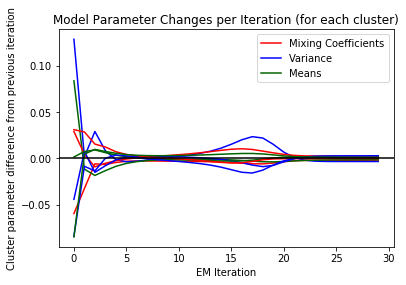

In [60]:
def track_changes(value_array):
    # Standardize each iteration element
    differences = []
    for i, iteration in enumerate(value_array):
        value_array[i] = [value/sum(iteration) for value in iteration]
        if i > 0:
            differences.append([value_array[i][k]-value_array[i-1][k] for k in range(len(iteration))])
    return list(map(list, zip(*differences)))

# Graph the changes in model parameters with each iteration
for i in range(len(track_changes(mix_coeff))):
    plt.plot(range(iter), track_changes(mix_coeff)[i], color='red', label='Mixing Coefficients')
    plt.plot(range(iter), track_changes(sigma)[i], color='blue', label='Variance')
    plt.plot(range(iter), track_changes(means)[i], color='darkgreen', label='Means')
    if i == 0:
        plt.legend(['Mixing Coefficients', 'Variance', 'Means'])
plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel('EM Iteration')
plt.ylabel('Cluster parameter difference from previous iteration')
plt.title('Model Parameter Changes per Iteration (for each cluster)')